# NeuralProphet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import HydroErr as he

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.descriptivestats import describe

from scipy.stats import zscore

from neuralprophet import NeuralProphet

import warnings
warnings.filterwarnings("ignore") #Evitamos que se muestren warnings

C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


### Importación de datos

In [2]:
#Cambiar por la serie a procesar

df = pd.read_csv('C:/Users/alexd/Desktop/ET/Puerto de la Cruz.csv')

#Procesamiento
df["ds"] =  pd.to_datetime(df["Fecha"], format="%d/%m/%Y")
df.set_index(df['ds'], inplace=True)

#Serie diaria
#df_d = df[['EtPMon','Temp Mínima (ºC)','Temp Max (ºC)','Velviento (m/s)','Radiación (MJ/m2)']]
df_d = df[['EtPMon','Temp Mínima (ºC)','Radiación (MJ/m2)']]


df_d.rename(columns={'EtPMon': 'y'}, inplace=True)
df_d= df_d[df_d['y'] != 0]
df_d=df_d.asfreq('D')
df_d.reset_index(inplace=True)
#df_d=df_d.fillna(method='bfill')
df_d.set_index(df_d['ds'], inplace=True)


In [3]:
def remove_outliers(df_in, col_name):
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3 -q1
        fence_low  = q1 -1.5 *iqr
        fence_high = q3 +1.5 *iqr
        df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
        return df_out
    
df_d = remove_outliers(df_d, 'y')

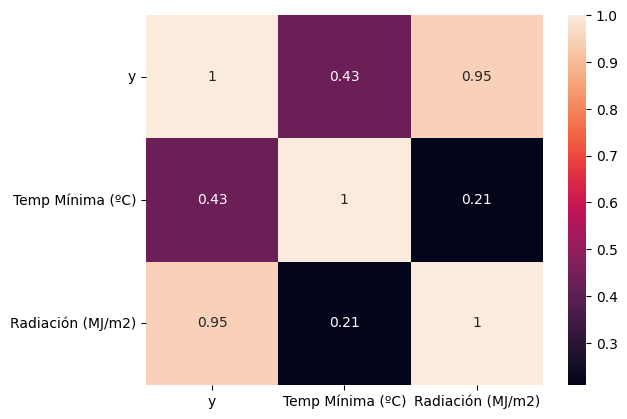

In [4]:
# Matriz de correlación

corr_matrix = df_d.corr()

sn.heatmap(corr_matrix, annot=True)
plt.show()

##### Valores de la serie diaria

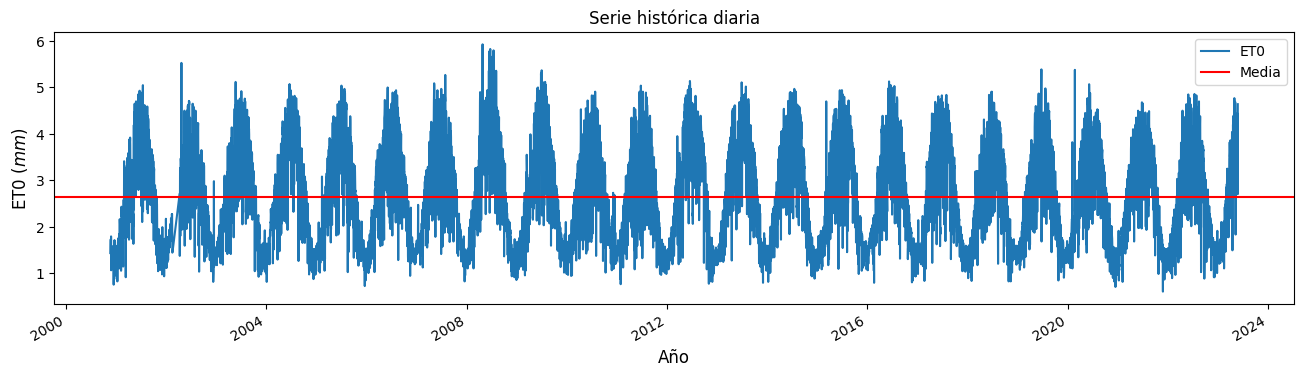

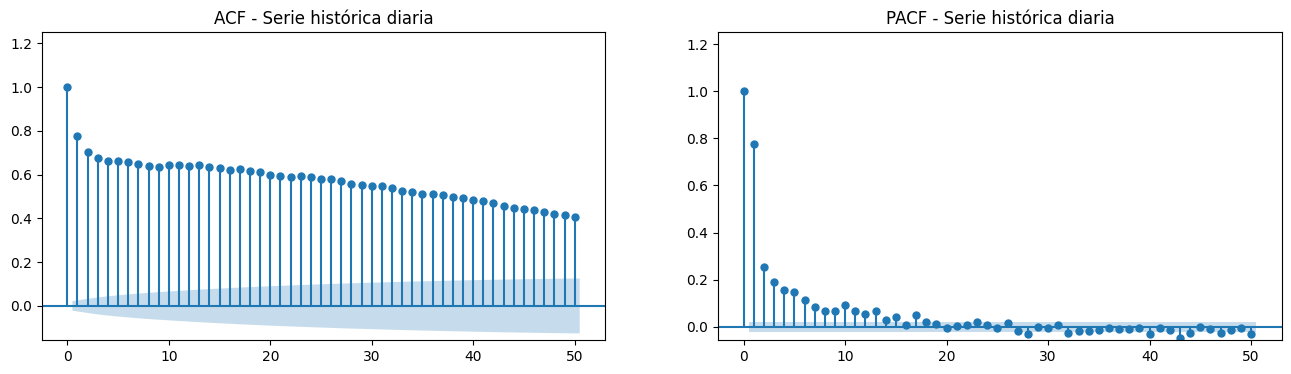

,y,Temp Mínima (ºC),Radiación (MJ/m2)
nobs,8.133000e+03,8.133000e+03,8.133000e+03
missing,0.000000e+00,2.000000e+00,2.000000e+00
mean,2.642828e+00,1.515511e+01,1.568434e+01
std_err,1.203043e-02,3.168886e-02,6.951267e-02
upper_ci,2.666407e+00,1.521722e+01,1.582058e+01
lower_ci,2.619249e+00,1.509300e+01,1.554810e+01
std,1.084942e+00,2.857450e+00,6.268100e+00
iqr,1.790000e+00,4.630000e+00,9.415000e+00
iqr_normal,1.326929e+00,3.432224e+00,6.979350e+00
mad,9.243227e-01,2.432625e+00,5.224982e+00


In [5]:
#Procesamiento de la serie histórica diaria

#Gráfica de la serie histórica
title='Serie histórica diaria'
df_d['y'].plot(title=title,figsize=(16, 4))
plt.axhline(y=np.nanmean(df_d.y),color="red",)
plt.xlabel('Año', fontsize=12)
plt.ylabel('ET0 ($mm$)', fontsize=12)
plt.legend(['ET0','Media'])

#Autocorrelograma
acf(df_d['y'])

#PACF
pacf(df_d['y'],alpha=.05)

lags = 50

#Gráficas conjuntas
fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(df_d['y'],title='ACF - Serie histórica diaria',lags=lags, auto_ylims=True, ax=ax[0])
plot_pacf(df_d['y'],title='PACF - Serie histórica diaria',lags=lags, auto_ylims=True, ax=ax[1])
plt.show()



#Estadísticas de la serie temporal
describe(df_d) 

### NeuralProphet

In [6]:
m = NeuralProphet(n_forecasts=7, drop_missing = True)

df_train, df_test = m.split_df(df_d, freq="D", valid_p=0.30)

m.add_lagged_regressor(['Temp Mínima (ºC)','Radiación (MJ/m2)'])

metrics = m.fit(df_d, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.631% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.631% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column Temp Mínima (ºC) were detected in total. 
INFO - (NP.data.processing._handle_missing_data_sing

Finding best initial lr:   0%|          | 0/247 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [7]:
forecast = m.predict(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.878% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.data.processing._handle_missing_data_single_id) - 2 missing values in column Radiación (MJ/m2) were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 2 NaN values in column Radiación (MJ/m2) were auto-imputed.


Predicting: 254it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [8]:
m.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~2D</i>',
              'type': 'scatter',
              'uid': 'df5af288-3931-4c4c-951c-4b73b63ae9a8',
              'x': array([datetime.datetime(2016, 9, 17, 0, 0),
                          datetime.datetime(2016, 9, 19, 0, 0),
                          datetime.datetime(2016, 9, 20, 0, 0), ...,
                          datetime.datetime(2023, 5, 21, 0, 0),
                          datetime.datetime(2023, 5, 25, 0, 0),
                          datetime.datetime(2023, 5, 26, 0, 0)], dtype=object),
              'y': array([2.81134653, 2.72624207, 2.71498108, ..., 3.47087622, 3.84517145,
                          3.4132576 ])},
             {'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 0.7714285714285714)', 'width':

In [9]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,lagged_regressor_Temp Mínima (ºC)1,...,lagged_regressor_Radiación (MJ/m2)1,lagged_regressor_Radiación (MJ/m2)2,lagged_regressor_Radiación (MJ/m2)3,lagged_regressor_Radiación (MJ/m2)4,lagged_regressor_Radiación (MJ/m2)5,lagged_regressor_Radiación (MJ/m2)6,lagged_regressor_Radiación (MJ/m2)7,trend,season_yearly,season_weekly
0,2016-09-16,2.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-09-17,2.50,2.811347,NaN,NaN,NaN,NaN,NaN,NaN,-0.063655,...,0.375148,NaN,NaN,NaN,NaN,NaN,NaN,2.220829,0.284968,-0.005944
2,2016-09-18,2.43,2.791470,2.934951,NaN,NaN,NaN,NaN,NaN,-0.056660,...,0.333925,0.318081,NaN,NaN,NaN,NaN,NaN,2.220748,0.265197,0.028261
3,2016-09-19,2.38,2.726242,2.828721,2.913723,NaN,NaN,NaN,NaN,-0.054815,...,0.323051,0.280257,0.265366,NaN,NaN,NaN,NaN,2.220666,0.245328,-0.007987
4,2016-09-20,2.57,2.714981,2.801461,2.841625,2.904998,NaN,NaN,NaN,-0.055977,...,0.329901,0.272462,0.233253,0.241561,NaN,NaN,NaN,2.220584,0.225364,-0.004890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,2023-05-22,4.36,3.574401,3.453794,3.501070,3.502141,3.547930,3.487350,3.400378,-0.113401,...,0.668324,0.328339,0.280434,0.251310,0.278746,0.239379,0.189521,2.276983,0.750482,-0.007987
2438,2023-05-23,4.44,3.753895,3.506127,3.466110,3.496159,3.515563,3.559439,3.491975,-0.147886,...,0.871562,0.359783,0.253822,0.242602,0.256008,0.270767,0.229753,2.277016,0.758093,-0.004890
2439,2023-05-24,4.43,3.795738,3.624208,3.483647,3.470417,3.505912,3.523117,3.558083,-0.154985,...,0.913398,0.443680,0.259897,0.225499,0.247169,0.248548,0.259109,2.277048,0.765801,-0.005524
2440,2023-05-25,2.70,3.845171,3.648521,3.590043,3.486090,3.487351,3.521954,3.530872,-0.161868,...,0.953966,0.450154,0.312680,0.225460,0.229071,0.239895,0.237734,2.277081,0.773598,0.002395


In [10]:
# Coeficientes

RMSE = he.rmse(forecast['yhat1'], forecast['y'])
MAE = he.mae(forecast['yhat1'], forecast['y'])
NSE = he.nse(forecast['yhat1'], forecast['y'])
R2 = he.r_squared(forecast['yhat1'], forecast['y'])

print('El valor de MAE obtenido es: '+str(MAE))
print('El valor de RMSE obtenido es: '+str(RMSE))
print('El valor de NSE obtenido es: '+str(NSE))
print('El valor de R2 obtenido es: '+str(R2))

El valor de MAE obtenido es: 0.45637615420885724
El valor de RMSE obtenido es: 0.5912561204607154
El valor de NSE obtenido es: 0.6779283400239514
El valor de R2 obtenido es: 0.6788906337091083
